# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

* Визуальный анализ ряда
* Стабилизация дисперсии (при необходимости)
* Выбор порядка дифференцирования
* Выбор начальных приближений для `p`, `q`, `P`, `Q`
* Обучение и сравнение моделей-кандидатов, выбор победителя
* Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения `p`, `q`, `P`, `Q`.
* Прогнозирование с помощью финальной модели.

In [77]:
! python3 -V
! pip3 freeze | grep -E 'matplotlib|pandas|statsmodels|scipy|python-dateutil'

Python 3.6.5
matplotlib==2.0.2
pandas==0.22.0
python-dateutil==2.7.2
scipy==1.0.0
statsmodels==0.8.0


In [79]:
import warnings
from datetime import datetime
from itertools import product

import matplotlib
import pandas
import statsmodels.api
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot
from scipy import special, stats

%matplotlib inline

## Визуальный анализ ряда

In [17]:
frame = pandas.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
frame.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


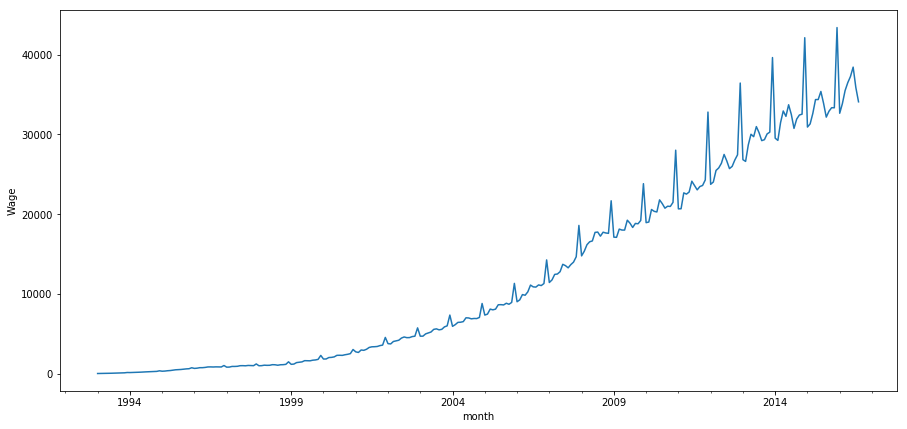

In [20]:
pyplot.figure(figsize=(15, 7))
pyplot.ylabel('Wage')
frame['WAG_C_M'].plot()
pyplot.show()

Ряд не стационарен, в нем имеется явно выраженный тренд. Кроме того, дисперсия зависит от времени.

In [26]:
print(f'Критерий Дики-Фуллера: p={statsmodels.api.tsa.stattools.adfuller(frame["WAG_C_M"])[1]}')

Критерий Дики-Фуллера: p=0.9918495954854734


Так я и думал.

## Стабилизация дисперсии

Как насчет Бокса-Кокса?

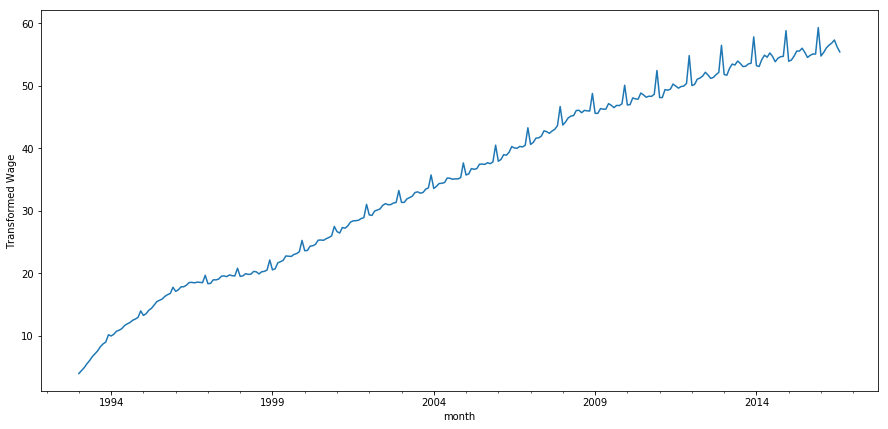

Критерий Дики-Фуллера: p=0.6968987634832726


In [36]:
frame['WAG_C_M_BOX'], lambda_ = stats.boxcox(frame['WAG_C_M'])

pyplot.figure(figsize=(15, 7))
pyplot.ylabel('Transformed Wage')
frame['WAG_C_M_BOX'].plot()
pyplot.show()

print(f'Критерий Дики-Фуллера: p={statsmodels.api.tsa.stattools.adfuller(frame["WAG_C_M_BOX"])[1]}')

Ряд все еще нестационарен. 🤔

Но в нем явно прослеживается тренд, давайте попробуем дифференцирование.

## Дифференцирование

Для начала, сезонное.

In [37]:
wage_diff = pandas.DataFrame(frame['WAG_C_M_BOX'] - frame['WAG_C_M_BOX'].shift(12)).dropna()
print(f'Критерий Дики-Фуллера: p={statsmodels.api.tsa.stattools.adfuller(wage_diff["WAG_C_M_BOX"])[1]}')

Критерий Дики-Фуллера: p=0.014697133494791775


Ух ты, гипотеза нестационарности отвергается. Но давайте взглянем на ряд глазами. На всякий случай.

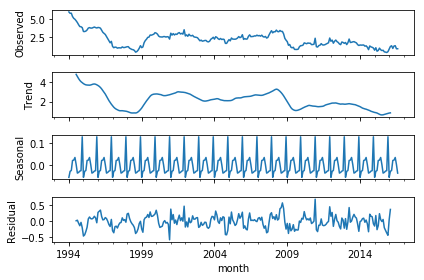

In [44]:
statsmodels.api.tsa.seasonal_decompose(wage_diff['WAG_C_M_BOX']).plot()
pyplot.show()

Я все еще вижу там тренд. 🔮

Давайте применим обычное дифференцирование.

In [45]:
wage_diff_2 = pandas.DataFrame(wage_diff['WAG_C_M_BOX'] - wage_diff['WAG_C_M_BOX'].shift(1)).dropna()
print(f'Критерий Дики-Фуллера: p={statsmodels.api.tsa.stattools.adfuller(wage_diff_2["WAG_C_M_BOX"])[1]}')

Критерий Дики-Фуллера: p=5.203603715821878e-08


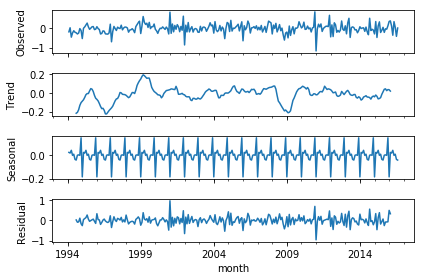

In [46]:
statsmodels.api.tsa.seasonal_decompose(wage_diff_2['WAG_C_M_BOX']).plot()
pyplot.show()

Вот теперь точно круто! Что у нас там дальше… а, магические константы.

## Выбор начальных приближений для параметров

ACF и PACF – это наше все!

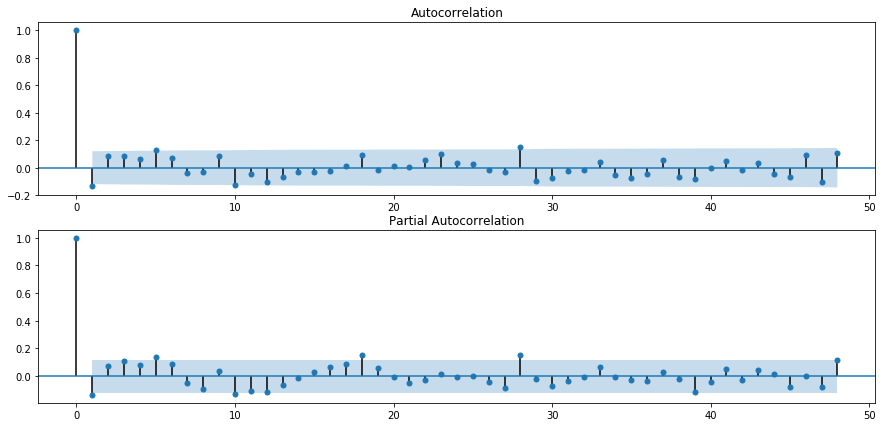

In [50]:
pyplot.figure(figsize=(15, 7))
ax = pyplot.subplot(211)
statsmodels.api.graphics.tsa.plot_acf(wage_diff_2['WAG_C_M_BOX'].values.squeeze(), lags=48, ax=ax)

ax = pyplot.subplot(212)
statsmodels.api.graphics.tsa.plot_pacf(wage_diff_2['WAG_C_M_BOX'].values.squeeze(), lags=48, ax=ax)
pyplot.show()

### `Q`

Единственный значимый сезонный лаг это `0`.

### `q`

Последний значимый несезонный лаг это `28`, но он слишком большой. Давайте возьмем `10` как последний значимый лаг внутри первого сезона.

### `P`

Вижу лаг `48`, но там значение пограничное. Ну а кроме него только `0`.

### `p`

Последний значимый лаг снова слишком большой. Давайте возьмем последний значимый лаг внутри сезона, `10`.

Ага, ну давайте обучаться.

## Обучение и сравнение моделей

In [68]:
%%time

warnings.filterwarnings('ignore')  # проблемы нет, если я ее не вижу, верно?

d = 1
D = 1

best_model = None

for p, q, P, Q in product(range(0, 11), range(0, 11), range(0, 1), range(0, 1)):
    try:
        model = statsmodels.api.tsa.statespace.SARIMAX(
            frame['WAG_C_M_BOX'],
            order=(p, d, q), seasonal_order=(P, D, Q, 12),
        ).fit(disp=-1)
    except ValueError:
        continue
    if best_model is None or model.aic < best_model.aic:
        best_model = model
        print(f'p={p}, q={q}, P={P}, Q={Q}: {model.aic}')

warnings.filterwarnings('default')

p=0, q=1, P=0, Q=0: 3.3698319753691486
p=0, q=2, P=0, Q=0: 2.1826087747664715
p=0, q=3, P=0, Q=0: 2.07777634201738
p=0, q=4, P=0, Q=0: 0.904278845353776
p=0, q=5, P=0, Q=0: -5.376635288100715
p=0, q=6, P=0, Q=0: -9.728442634241226
p=0, q=8, P=0, Q=0: -10.991223006267525
p=0, q=9, P=0, Q=0: -14.06523609651893
p=3, q=5, P=0, Q=0: -15.243199149147387
p=5, q=5, P=0, Q=0: -23.154513806359617
CPU times: user 1min 49s, sys: 6.88 s, total: 1min 55s
Wall time: 1min 56s


Так, и что там наобучалось?

In [70]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        WAG_C_M_BOX   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  22.577
Date:                            Fri, 06 Apr 2018   AIC                            -23.155
Time:                                    21:34:17   BIC                             16.984
Sample:                                01-01-1993   HQIC                            -7.062
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0503      7.325      0.007      0.995     -14.306      14.407
ar.L2          0.0141      5.108      0.003      0.998      -9.996      10.025
ar.L3          0.5494      3.242      0.169      0.865      -5.805       6.904
ar.L4         -0.0953      6.138     -0.016      0.988     -12.125      11.935
ar.L5         -0.4219      4.671     -0.090      0.928      -9.577       8.734
ma.L1         -0.2668      7.328     -0.036      0.971     -14.630      14.097
ma.L2          0.0873      6.727      0.013      0.990     -13.098      13.273
ma.L3         -0.5107      5.019     -0.102      0.919     -10.348       9.327
ma.L4          0.3294      6.972      0.047      0.962     -13.335      13.994
ma.L5          0.6129      6.909      0.089      0.929     -12.929      14.155
sigma2         0.0485      0.010      4.627      0.000       0.028       0.069
===================================================================================
Ljung-Box (Q):                       33.18   Jarque-Bera (JB):                50.14
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

И что по остаткам?

## Анализ остатков

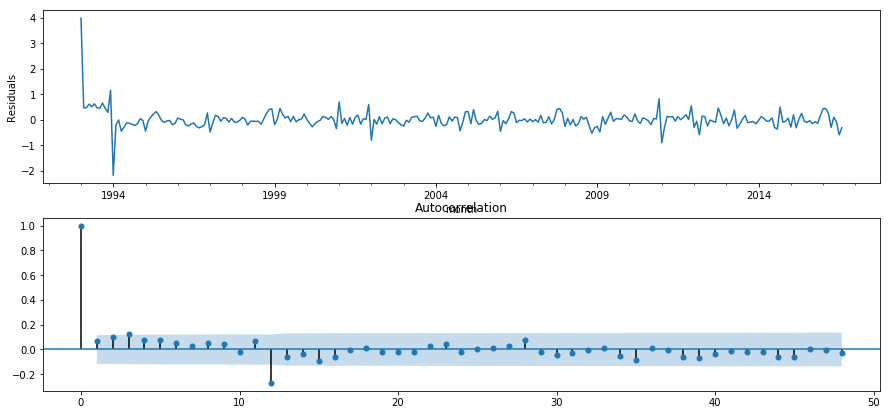

Критерий Стьюдента: p=0.5439116219193172
Критерий Дики-Фуллера: p=0.0


In [71]:
pyplot.figure(figsize=(15, 7))
pyplot.subplot(211)
pyplot.ylabel('Residuals')
best_model.resid.plot()

ax = pyplot.subplot(212)
statsmodels.api.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

pyplot.show()

print(f'Критерий Стьюдента: p={stats.ttest_1samp(best_model.resid, 0)[1]}')
print(f'Критерий Дики-Фуллера: p={statsmodels.api.tsa.stattools.adfuller(best_model.resid)[1]}')

Круто: остатки несмещены, стационарны и неавтокоррелированны.

А оно вообще в адеквате?

*Кстати, в `scipy` уже есть `inv_boxcox`.*

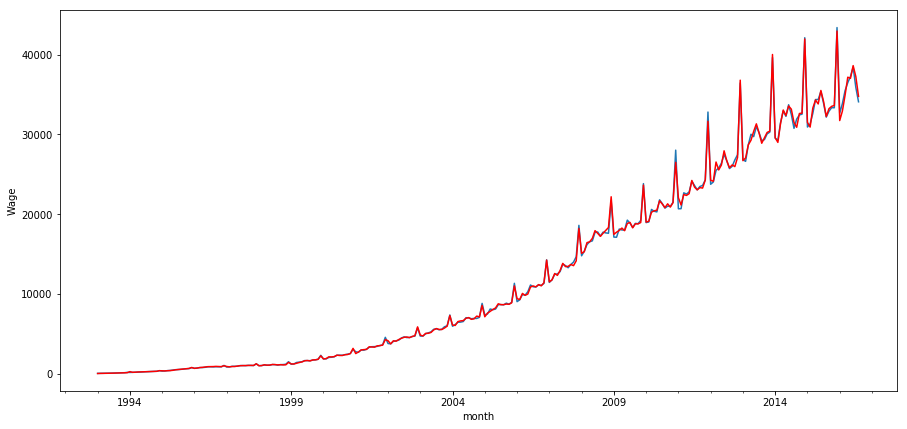

In [72]:
frame['model'] = special.inv_boxcox(best_model.fittedvalues, lambda_)
pyplot.figure(figsize=(15, 7))
frame['WAG_C_M'].plot()
frame['model'].plot(color='r')
pyplot.ylabel('Wage')
pyplot.show()

Вауууу. И что день грядущий нам готовит?

## Прогнозирование

In [75]:
frame.shape

(284, 3)

In [76]:
frame.tail()

,WAG_C_M,WAG_C_M_BOX,model
month,,,
2016-04-01,36497.0,56.526742,37181.643680
2016-05-01,37270.0,56.860441,37036.040508
2016-06-01,38447.0,57.358885,38634.744477
2016-07-01,35888.0,56.260153,37250.419341
2016-08-01,34095.0,55.455409,34775.999084


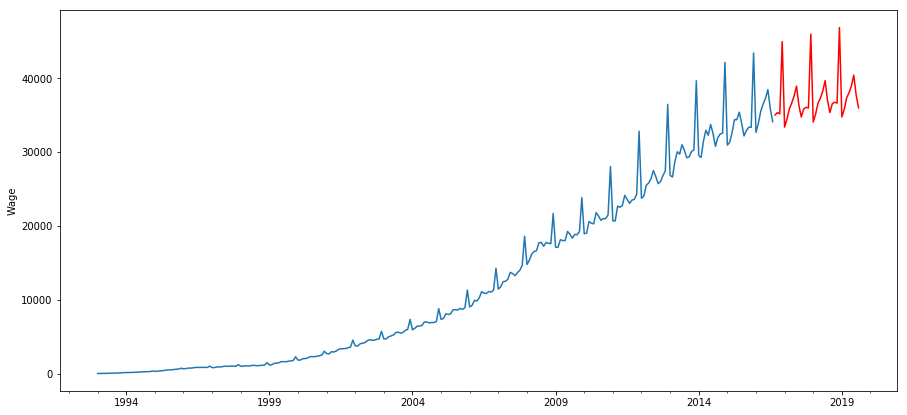

In [95]:
n_months = 36

frame_2 = frame[['WAG_C_M']]
dates = [frame_2.index[-1] + relativedelta(months=months) for months in range(1, n_months + 1)]
future = pandas.DataFrame(index=dates, columns=frame_2.columns)
frame_2 = pandas.concat([frame_2, future])
frame_2['forecast'] = special.inv_boxcox(best_model.predict(start=frame.shape[0], end=(frame.shape[0] + n_months)), lambda_)

pyplot.figure(figsize=(15, 7))
frame_2['WAG_C_M'].plot()
frame_2['forecast'].plot(color='r')
pyplot.ylabel('Wage')
pyplot.show()

Вроде выглядит адекватно, не так ли?